# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 1: Data Cleaning and Exploratory Data Analysis (EDA)

This notebook contains the Problem Statement and code for data cleaning and EDA.

<div class="alert alert-block alert-info">
Note: This notebook takes approx. 17s to run on a PC with an Intel i7-8565U CPU, 16GB of RAM and Windows 10 operating system.
</div>

### Contents

- [Problem Statement](#Problem-Statement)
- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
    - [Import Training Datasets](#Import-Training-Datasets)
    - [Import Testing Datasets](#Import-Testing-Datasets)
- [Data Cleaning and Munging](#Data-Cleaning-and-Munging)
    - [Cleaning the Training Dataset](#Cleaning-the-Training-Dataset)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
    - [EDA on Variation Classes](#EDA-on-Variation-Classes)
    - [EDA on Clinical Text](#EDA-on-Clinical-Text)
    - [EDA on Genes](#EDA-on-Genes)
    - [EDA on Variations](#EDA-on-Variations)
- [Baseline Accuracy](#Baseline-Accuracy)
- [Data Export](#Data-Export)

## Problem Statement

To build and train a classifier to classify genetic variations based on an expert-annotated knowledge base of cancer mutation annotations, so that clinical pathologists can review the medical literature to make the classification, faster and with less effort. As shown in the "Data Interpretation" step within the diagram below, this review is a critical part of the end-to-end precision oncology workflow.

Fast and accurate classification of cancer mutation annotations can help to speed up diagnosis and identification of the correct treatment to deliver to affected patients.

The classifier's performance will be measured by the following:
- **Balanced accuracy score**: this metric caters for class imbalance and is the average of recall obtained on each variation class. This is especially important in our context, because we seek high recall (i.e. sensitivity) to ensure that we carry out the appropriate interventions in a timely manner, based on the  variation classification. The goal is to achieve a balanced accuracy score that is at least 10% better than the baseline accuracy, which is defined as the proportion of the majority variant class in the given training set.
- **Balanced F1 score**: this considers both the precision and recall, and is weighted by the number of true instances of each variation class to account for class imbalance.
- **Micro-average Area under Curve (AUC) score**: this metric looks at the average area under the Receiver Operating Characteristic (ROC) curve for each of the nine classes. The average is taken by the sum of counts to obtain cumulative metrics (true-positives, false-negatives, true-negatives and false-positives) across all classes, and then calculating the AUC.

<img src="../assets/workflow.jpg" height="500" width="500"/>

Source: Kumar-Sinha, C., Chinnaiyan, A. Precision oncology in the age of integrative genomics. Nat Biotechnol 36, 46–60 (2018). https://doi.org/10.1038/nbt.4017

In [1]:
# For tracking the execution time for the entire notebook
import time
import datetime
now = datetime.datetime.now()
print ("Started executing notebook at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
notebook_start = time.time()

Started executing notebook at: 2020-04-15 09:11:52


---

## Importing of Libraries

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Import

### Import Training Datasets

In [3]:
train_text = pd.read_csv("../assets/training_text.txt", sep="\|\|", engine='python')
train_variants = pd.read_csv("../assets/training_variants.txt")

In [4]:
train_text.shape, train_variants.shape

((3321, 1), (3321, 4))

In [5]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID,Text  3316 non-null   object
dtypes: object(1)
memory usage: 51.9+ KB


We notice that there are missing values for 'text' that we need to clean up.

In [6]:
train_text.head()

,"ID,Text"
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
train_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


We note that there are no missing data in the train_variants data.

In [8]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### Import Testing Datasets

In [9]:
test_text = pd.read_csv("../assets/test_text.csv", sep="\|\|", engine='python')
test_variants = pd.read_csv("../assets/test_variants.csv")

In [10]:
test_text.shape, test_variants.shape

((986, 1), (986, 3))

In [11]:
test_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 1 to 986
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID,Text  986 non-null    object
dtypes: object(1)
memory usage: 15.4+ KB


We note that there are no missing data in the test_text dataset.

In [12]:
test_text.head()

,"ID,Text"
1,The incidence of breast cancer is increasing i...
2,An unselected series of 310 colorectal carcino...
3,Mycosis fungoides and SÃ©zary syndrome are pri...
4,Regulated progression through the cell cycle ...
5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [13]:
test_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         986 non-null    int64 
 1   Gene       986 non-null    object
 2   Variation  986 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.2+ KB


We note that there are no missing data in the test_variants data.

In [14]:
test_variants.head()

,ID,Gene,Variation
0,1,CHEK2,H371Y
1,2,AXIN2,Truncating Mutations
2,3,WNT4,E216G
3,4,SUCLA2,G118R
4,5,BRAF,T599insTT


## Data Cleaning and Munging

In [15]:
# Create 'id' columns
train_text['id'] = train_text.index
test_text['id'] = test_text.index

In [16]:
# Rename the columns
train_text.rename(columns = {'ID,Text':'text'}, inplace = True)
test_text.rename(columns = {'ID,Text':'text'}, inplace = True)

In [17]:
train_text = train_text[['id','text']]
test_text = test_text[['id','text']]

In [18]:
train_variants.columns = [x.lower() for x in train_variants.columns]
test_variants.columns = [x.lower() for x in test_variants.columns]

In [19]:
# merge the "_text" and "_variant" files for both training and test
train = train_text.merge(train_variants)
test = test_text.merge(test_variants)

In [20]:
train.shape, test.shape

((3321, 5), (986, 4))

### Cleaning the Training Dataset

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   text       3316 non-null   object
 2   gene       3321 non-null   object
 3   variation  3321 non-null   object
 4   class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


We note from the above that there is missing text for a number of the samples.

In [22]:
train[train['text'].isnull()]

,id,text,gene,variation,class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


Given that the classifications of gene and variant to the target feature ('class') are important, we do not remove the missing rows. Instead, we replace the missing values with an empty string.

In [23]:
train['text'] = train['text'].fillna("")

In [24]:
# We verify that there are no more missing data in the 'text' column
train[train['text'].isnull()]

,id,text,gene,variation,class


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   text       3321 non-null   object
 2   gene       3321 non-null   object
 3   variation  3321 non-null   object
 4   class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


## Exploratory Data Analysis (EDA)

In [26]:
train.describe(include='all')

,id,text,gene,variation,class
count,3321.000000,3321,3321,3321,3321.000000
unique,NaN,1921,264,2996,NaN
top,NaN,The PTEN (phosphatase and tensin homolog) phos...,BRCA1,Truncating Mutations,NaN
freq,NaN,53,264,93,NaN
mean,1660.000000,NaN,NaN,NaN,4.365854
std,958.834449,NaN,NaN,NaN,2.309781
min,0.000000,NaN,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,NaN,7.000000


We note that there are actually duplicate 'text' values given that we have only 1,921 unique entries of 'text' out of the total of 3,321 rows.

### EDA on Variation Classes

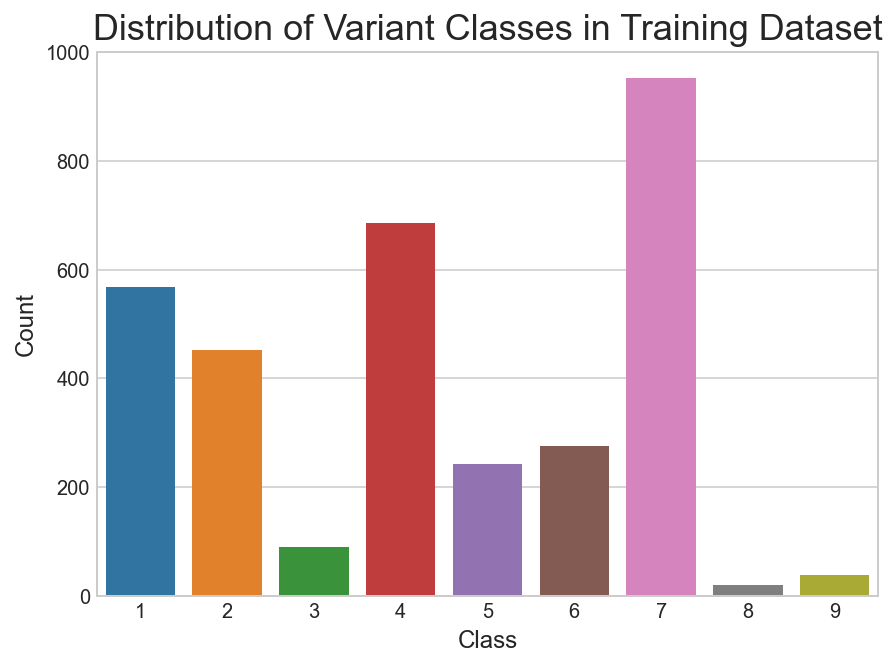

In [43]:
plt.figure(figsize=(7,5))
sns.countplot(train['class'])
plt.title('Distribution of Variant Classes in Training Dataset', fontsize=18);
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12);

We note above that the **training set is highly imbalanced** -- i.e. classes 4 and 7 alone take up almost 50% of all classes found in the training set. We will need to deal with this when we fit the various candidate classifiers.

### EDA on Clinical Text

We now take a closer look at some statistics for the 'text' length.

In [28]:
train['text'].str.len().describe()

count      3321.000000
mean      63865.602830
std       52373.225851
min           0.000000
25%       31450.000000
50%       46292.000000
75%       80347.000000
max      525740.000000
Name: text, dtype: float64

In [29]:
print ("Skew: {}".format(train['text'].str.len().skew()))
print ("Kurtosis: {}".format(train['text'].str.len().kurtosis()))

Skew: 2.6501447822500057
Kurtosis: 10.972881565762028


The skewness is positive (2.65) which represents a right skewed distribution. The high kurtosis (>3) means that there are more outliers than the normal distribution.

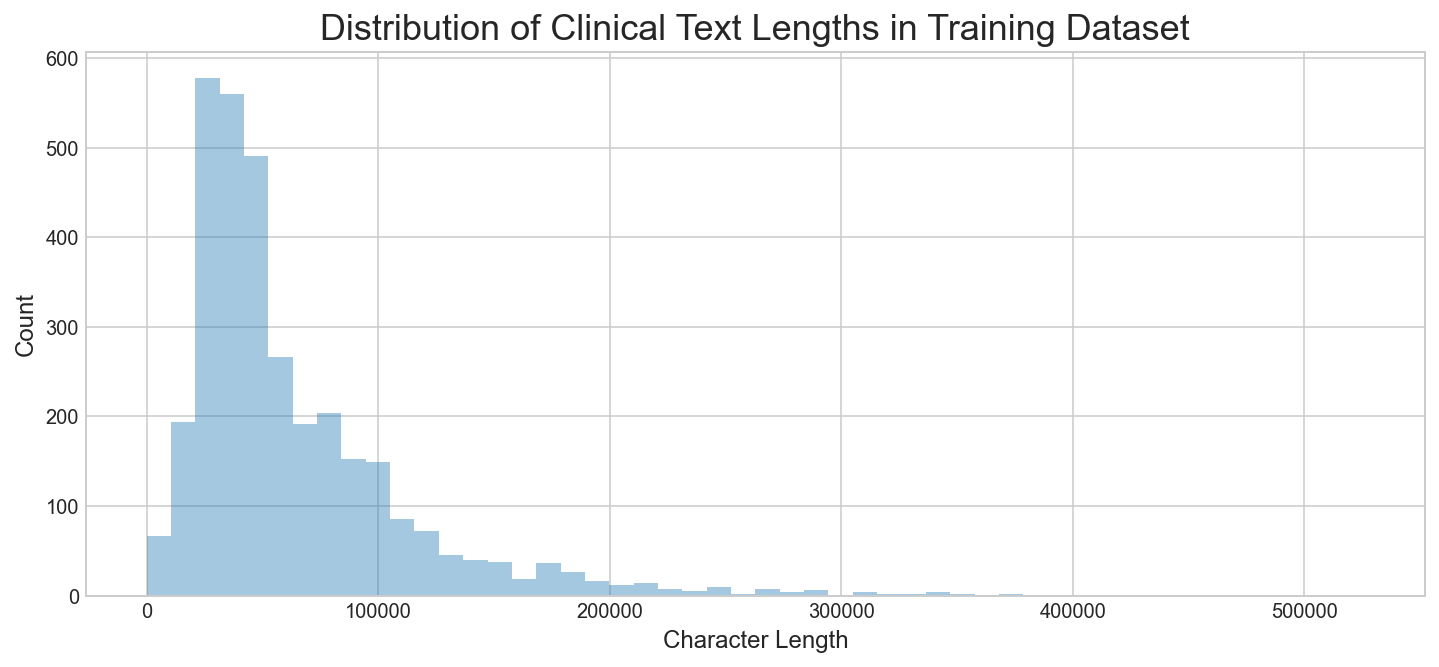

In [46]:
fig = plt.figure(figsize=(12,5))
sns.distplot(train['text'].str.len(), kde=False);
plt.title("Distribution of Clinical Text Lengths in Training Dataset", fontsize=18)
plt.xlabel("Character Length", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show(fig)

The plot above shows the right skewed distribution of clinical text lengths over all classes, in the training dataset.

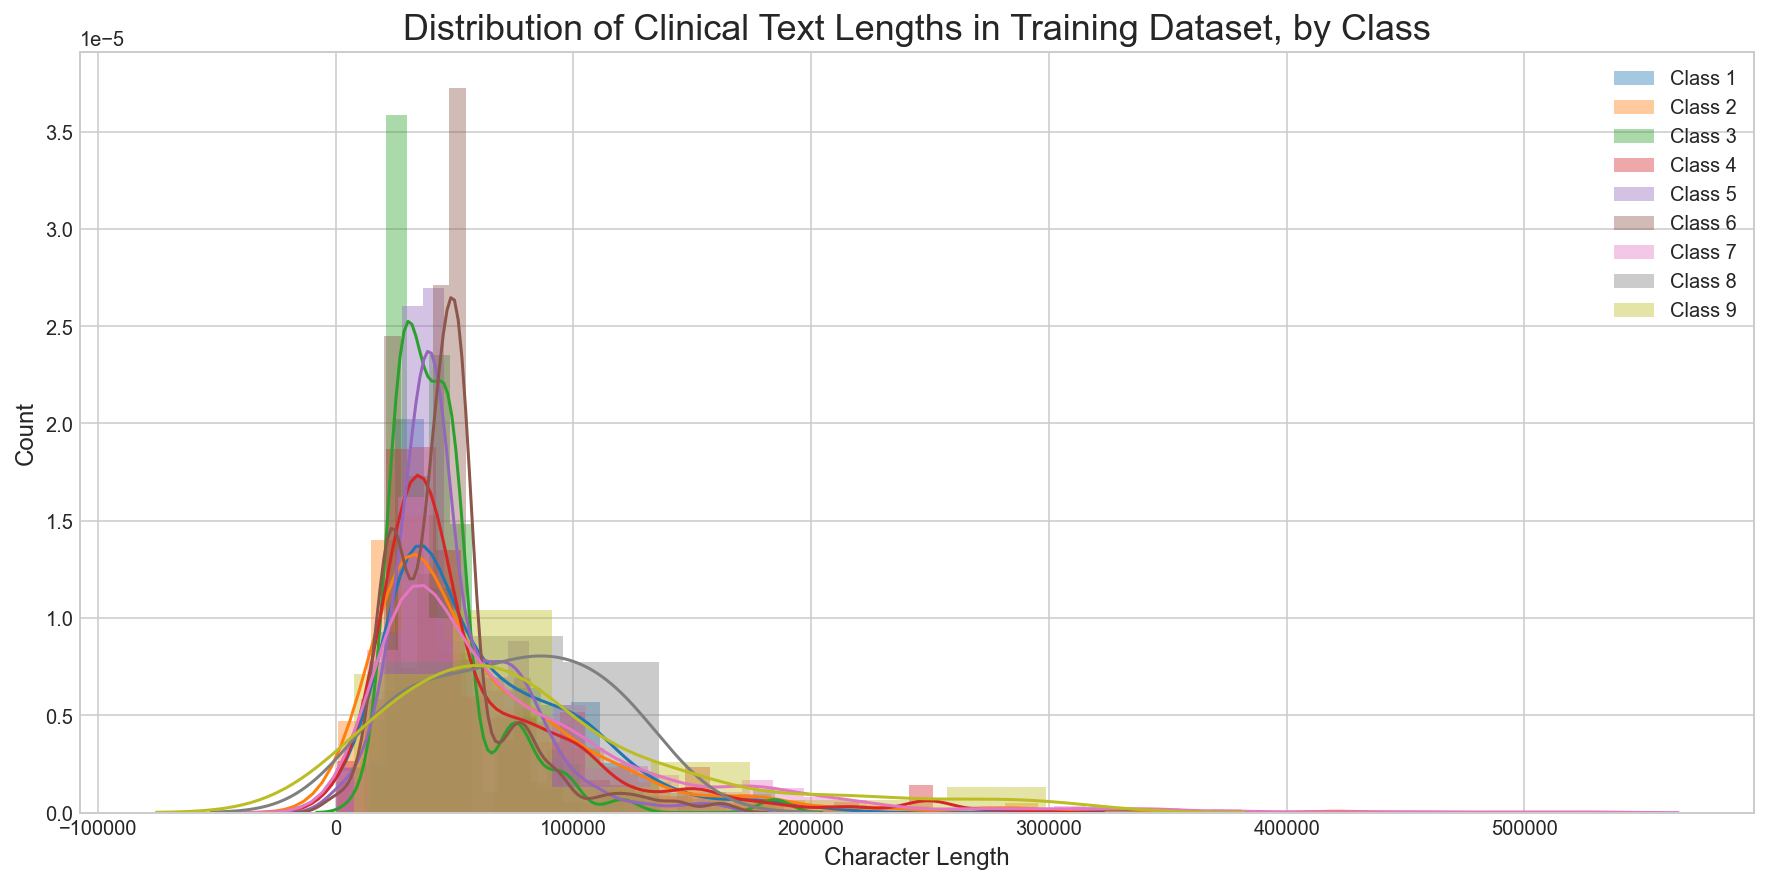

In [42]:
fig = plt.figure(figsize=(15,7))
for cls in range(1, 10):
    sns.distplot(train.loc[train['class']==cls, :]['text'].str.len(),
                 kde=True, label='Class '+str(cls), hist_kws = {'alpha':0.4});
plt.title("Distribution of Clinical Text Lengths in Training Dataset, by Class", fontsize=18)
plt.xlabel("Character Length", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.show(fig)

We see above that all the 9 classes follow a roughly similar distribution, based on the kernel density estimate curves.

We now use boxplots to examine the distribution of text lengths across the different classes.

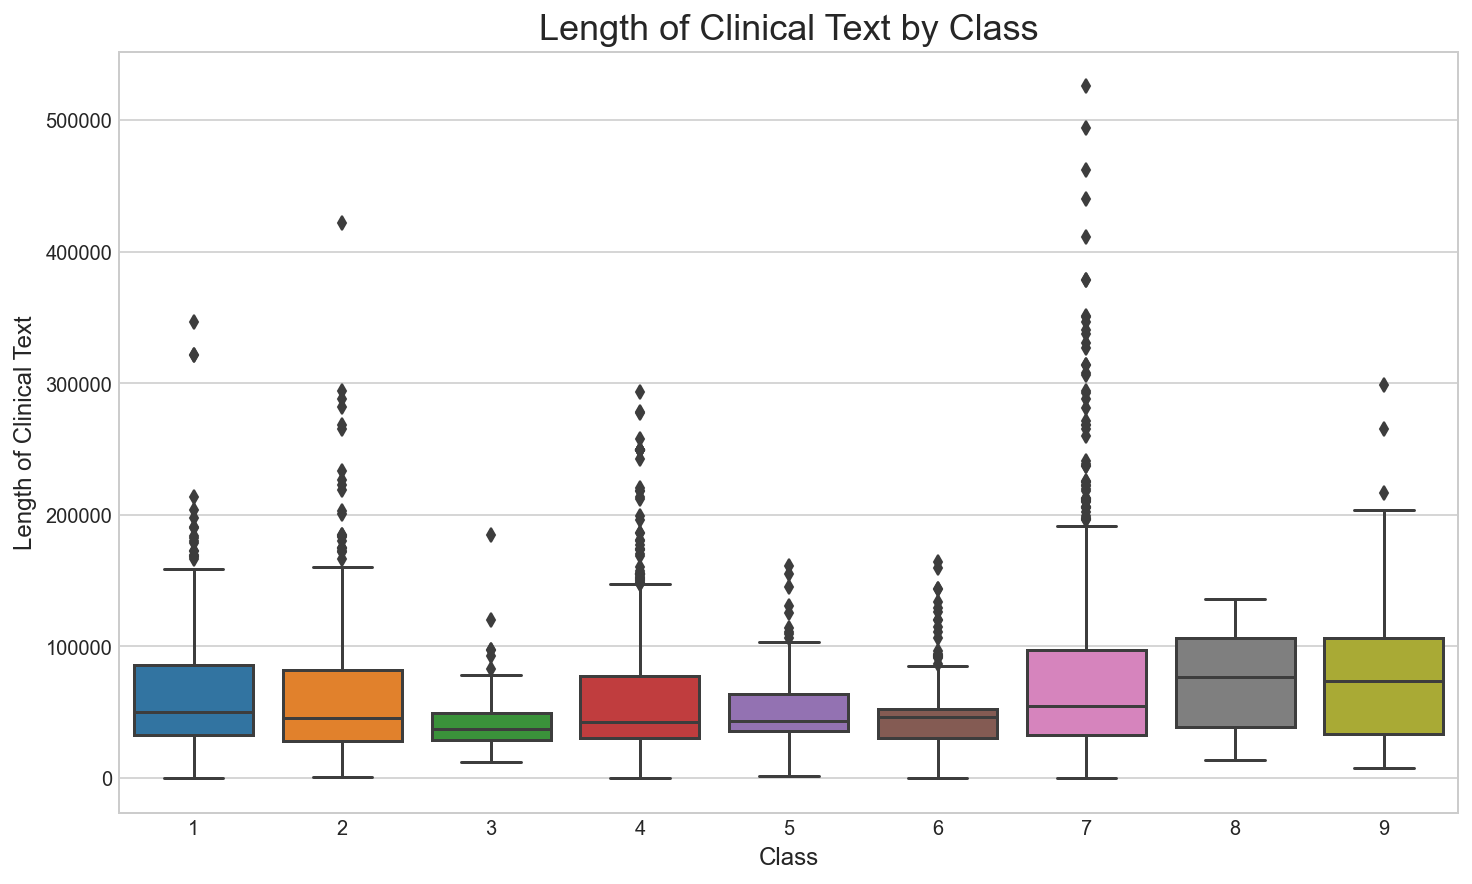

In [32]:
plt.figure(figsize=(12,7))
sns.boxplot(x='class', y=train['text'].str.len(), data=train)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Length of Clinical Text", fontsize=12)
plt.title("Length of Clinical Text by Class", fontsize=18);

We observe above that the medians (i.e. horizontal line within each box), 25th and 75th quartiles (lower and upper edge of each box respectively) for all the classes are generally the same. However what stands out is classes 7, which have many extreme outliers. These outliers represent lengths that extend beyond the sum of the 75th quartile and 1.5 times the inter-quartile range. **We choose not to remove the outliers** from any of the classes, as they may contain valuable words that are needed to distinguish their respective class from the other classes.

### EDA on Genes

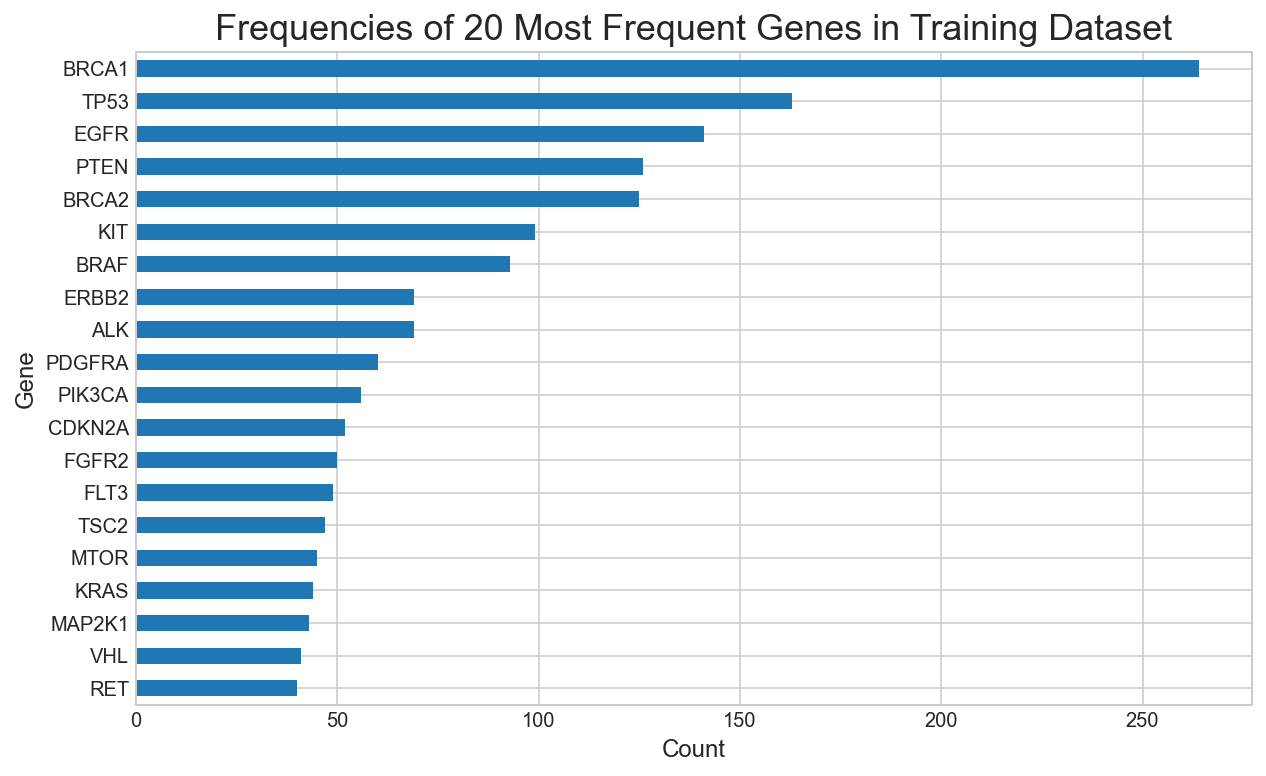

In [45]:
fig = plt.figure(figsize=(10,6))
plt.title('Frequencies of 20 Most Frequent Genes in Training Dataset', fontsize=18);
plt.xlabel("Count", fontsize=12)
plt.ylabel("Gene", fontsize=12)
train['gene'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

The top 3 mentioned genes are:
- BRCA1: BRCA1 is a human tumor suppressor gene and is responsible for repairing DNA. BRCA mutations increase the risk for breast cancer.
- TP53: The tumour protein 53 gene prevents cancer formation and functions as a tumour suppressor; there is some evidence (albeit controversial) that links TP53 mutations and cancer.
- EGFR: Mutations that lead to the overexpression of the Epidermal growth factor receptor (EGFR) protein have been associated with a number of cancers.

### EDA on Variations

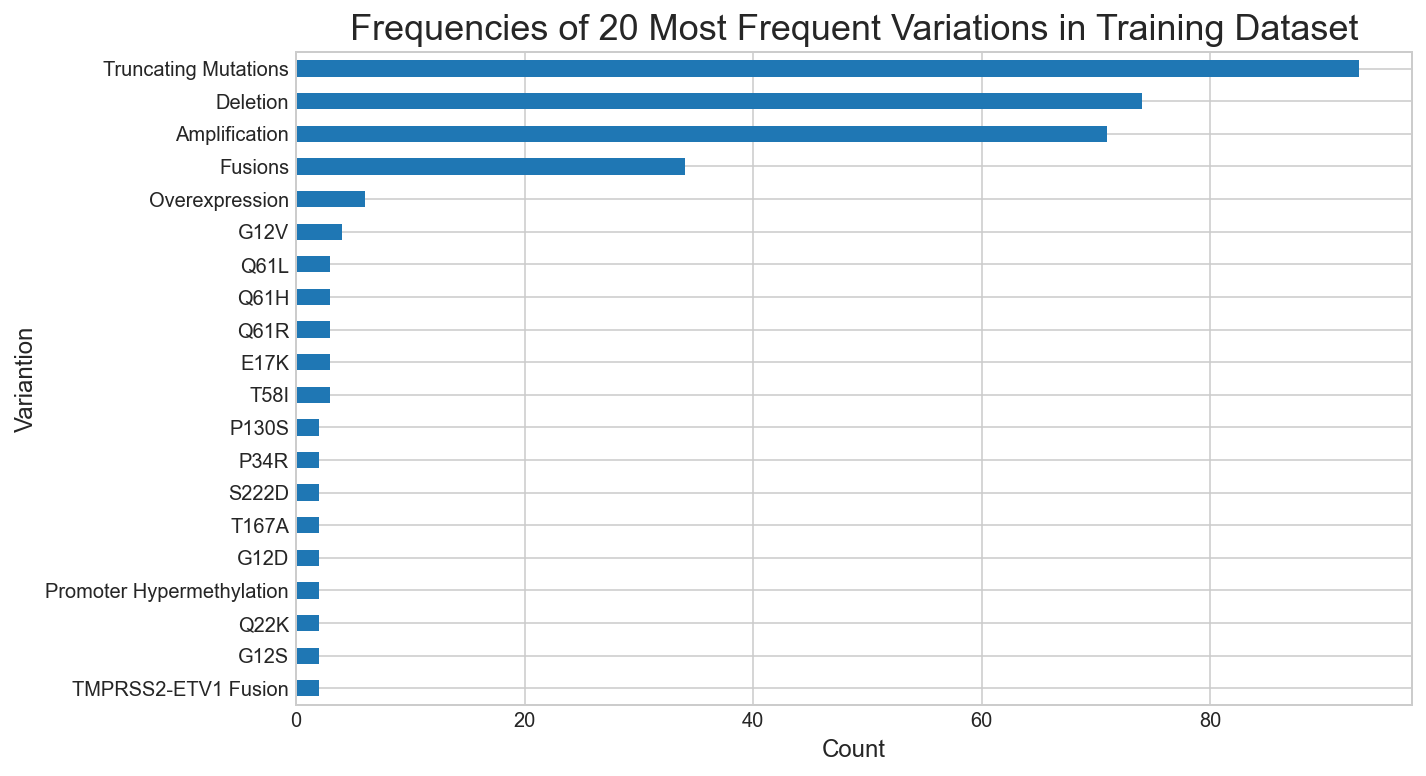

In [44]:
fig = plt.figure(figsize=(10,6))
plt.title('Frequencies of 20 Most Frequent Variations in Training Dataset', fontsize=18);
plt.xlabel("Count", fontsize=12)
plt.ylabel("Variantion", fontsize=12)
train['variation'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

The top 3 mentioned variations are:
- Truncating mutations: a change in DNA that truncates (or shortens) a protein.
- Deletions: a mutation where a part of a chromosome or a sequence of DNA is left out during DNA replication.
- Amplification: a mutation that involves an increase in the number of copies of a gene; gene amplification is common in cancer cells.

## Baseline Accuracy

We need to calculate baseline accuracy in order to tell if our model is outperforming the null model (predicting the majority class).

In [35]:
train['class'].value_counts(normalize=True)

7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: class, dtype: float64

The proportion of the data points having the 'class' of 7 (i.e. **0.286962**) serves as our baseline (y-mean) statistic. Any model we create should not perform worse than this statistic.

## Data Export

We now export the cleaned training and testing datasets.

In [36]:
train.shape, test.shape

((3321, 5), (986, 4))

In [37]:
# write out the csv files for subsequent pre-processing
train.to_csv("../assets/train_clean.csv", index=False)
test.to_csv("../assets/test_clean.csv", index=False)

---

In [38]:
# For tracking the execution time for the entire notebook
print ("Notebook execution duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-notebook_start))))

Notebook execution duration (h:m:s): 0:00:16.812680
